In [1]:
import pandas as pd
import numpy as np
import json
import os
from pprint import pprint
import glob
from functools import lru_cache

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
!ls

CORD-19-Topic-Modeling.ipynb  ldavisualization_50.html
CORD-19_BERT_clustering.ipynb subset_corpus
CORD_DATA                     subset_corpus.npy
README.md                     subset_corpus.pkl
ldavisualization_50


In [3]:
#read in metadata
root_dir = './CORD_DATA/'
metadata_path = root_dir + 'metadata.csv'
metadata = pd.read_csv(metadata_path)

metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389


### Read Data Into Dataframes

In [4]:
%%time
#DATA DIRECTORIES
        
biorxiv_medrxiv    = root_dir + 'biorxiv_medrxiv/biorxiv_medrxiv/'
comm_use_subset    = root_dir + 'comm_use_subset/comm_use_subset/'
noncomm_use_subset = root_dir + 'noncomm_use_subset/noncomm_use_subset/'

search_params = biorxiv_medrxiv + '**/*.json'
biorxiv_medrxiv_files       = glob.glob(search_params)
search_params = comm_use_subset + '**/*.json'
comm_use_subset_files       = glob.glob(search_params)
search_params = noncomm_use_subset + '**/*.json'
noncomm_use_subset_files    = glob.glob(search_params)

pprint(biorxiv_medrxiv_files[:10])
print('Total biorxiv_medrxiv_files: {}'.format(len(biorxiv_medrxiv_files)))
print('Total comm_use_subset_files: {}'.format(len(comm_use_subset_files)))
print('Total noncomm_use_subset_files: {}'.format(len(noncomm_use_subset_files)))
print('Total files: {}'.format(len(biorxiv_medrxiv_files) + len(comm_use_subset_files) + len(noncomm_use_subset_files)))

['./CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/f905f78b32f63c6d14a79984dfb33f1b358b8ab4.json',
 './CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/607e0074d8ff40c272b958c2fe48793fedfc785e.json',
 './CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/7cfaa2540d3c8eea0982b3b1147884f125f67ff2.json',
 './CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/abcfffafab399149d4adadd6bb458c4994e2025d.json',
 './CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/0cb9c296684ca5e71462d825cab2827854a01544.json',
 './CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/9bbfd3d34ee18ea1b9f4669331a6cee9c5992893.json',
 './CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/1218f278a4f8d83dac14b23c8f698062812ef9d5.json',
 './CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/a59906b732bf4a489e282c3e4f499d4166c622e7.json',
 './CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/baabfb35a321ea12028160e0d2c1552a2fda2dd5.json',
 './CORD_DATA/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/240da1ff435355a853

In [5]:
'''
    @Desc    : Reads in json article and converts into Pandas Dataframe
    @Params  : filepath (str)
    @Returns : Pandas Dataframe 
'''

def JsonToDataFrame(filepath):
        
    #read json into dict
    with open(filepath) as json_data:
        data = json.load(json_data)
        
        paper_id = data['paper_id']
        abstract = '\n'.join([section['text'] for section in data['abstract']])

        

        final_data = {
            'paper_id'  : [data['paper_id']],
            'section'   : ['abstract'],
            'text'  : ['\n'.join([section['text'] for section in data['abstract']])]                                       
        }
        
        df = pd.DataFrame.from_dict(final_data)
        for section in data['body_text']:
            df = df.append({
                'paper_id' : data['paper_id'],
                'section'  : section['section'],
                'text'     : section['text']
            }, ignore_index=True)
            
        return df 

In [6]:
%%time
import concurrent
#initialize dfs
biomed_df      = pd.DataFrame()
comm_use_df    = pd.DataFrame()
noncomm_use_df = pd.DataFrame()

count = 0

def to_df(file):
    try:
        return JsonToDataFrame(file)
    except:
        global count 
        count += 1
        return None

with concurrent.futures.ProcessPoolExecutor() as executor:
        for _, df in zip(biorxiv_medrxiv_files, executor.map(to_df, biorxiv_medrxiv_files)):
            if df is not None:
                biomed_df = biomed_df.append(df, ignore_index=True)
            
with concurrent.futures.ProcessPoolExecutor() as executor:
        for _, df in zip(comm_use_subset_files, executor.map(to_df, comm_use_subset_files)):
            if df is not None:
                comm_use_df = comm_use_df.append(df, ignore_index=True)
            
with concurrent.futures.ProcessPoolExecutor() as executor:
        for _, df in zip(noncomm_use_subset_files, executor.map(to_df, noncomm_use_subset_files)):
            if df is not None:
                noncomm_use_df = noncomm_use_df.append(df, ignore_index=True)
            
print('Count of files with issues: {}'.format(count))
full_corpus = pd.concat([biomed_df, comm_use_df, noncomm_use_df])

Count of files with issues: 0
CPU times: user 2min 14s, sys: 8.29 s, total: 2min 22s
Wall time: 3min 4s


In [7]:
print(full_corpus.shape)
full_corpus.head()

(432691, 3)


,paper_id,section,text
0,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,abstract,New anti-AIDS treatments must be continually d...
1,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,"In the absence of a curative treatment, the hi..."
2,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,Tetramers of IN are formed by the reciprocal s...
3,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,Hindering the assembly of IN functional multim...
4,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,Based on the structure of Fab specific to IN C...


In [8]:
full_corpus['section'].value_counts()

Discussion                                             38758
Introduction                                           22111
                                                       14154
abstract                                               13084
Results                                                10229
                                                       ...  
Nsp14                                                      1
392!                                                       1
MERS-CoV shedding in bats inoculated with MERS-CoV.        1
Determinants of psychological distress                     1
MATERIAL AND METHODS Cohort description                    1
Name: section, Length: 89867, dtype: int64

In [9]:
%%time
import re
import string

punct_table = str.maketrans('', '', string.punctuation)

#remove punctuation
full_corpus['text'] = full_corpus['text'].map(lambda x: x.translate(punct_table))

#convert to lowercase
full_corpus['text'] = full_corpus['text'].map(lambda x: x.lower())

CPU times: user 8.93 s, sys: 259 ms, total: 9.19 s
Wall time: 9.19 s


In [10]:
full_corpus.head()

,paper_id,section,text
0,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,abstract,new antiaids treatments must be continually de...
1,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,in the absence of a curative treatment the hig...
2,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,tetramers of in are formed by the reciprocal s...
3,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,hindering the assembly of in functional multim...
4,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,based on the structure of fab specific to in c...


In [11]:
full_corpus['text']

0        new antiaids treatments must be continually de...
1        in the absence of a curative treatment the hig...
2        tetramers of in are formed by the reciprocal s...
3        hindering the assembly of in functional multim...
4        based on the structure of fab specific to in c...
                               ...                        
77381    it is easy to pontificate and write pages of p...
77382    only then can we see the shortcomings of human...
77383    the numerous missteps misspeaks and misdeeds o...
77384            financial disclosure none funding support
77385    none conflicts of interest no authors have fin...
Name: text, Length: 432691, dtype: object

In [12]:
full_corpus.describe()

,paper_id,section,text
count,432691,432691,432691
unique,13084,89867,413954
top,ce6717ad3bb0da86077a5cbb8111576ea8230b2c,Discussion,
freq,2022,38758,1908


In [14]:
%%time
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

stopwords = list(stopwords.words('english')) + ['et', 'al'] + [str(year) for year in range(1999,2020)]
#transfrom data into Bag-Of-Words Representation
count_vectorizer = CountVectorizer(stop_words=stopwords)

bag_of_words = count_vectorizer.fit_transform(full_corpus['text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clayharper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 32.2 s, sys: 473 ms, total: 32.7 s
Wall time: 32.7 s


In [15]:
print("Unique words: {} ".format(len(count_vectorizer.get_feature_names())))

Unique words: 633162 


In [16]:
full_corpus.head()

,paper_id,section,text
0,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,abstract,new antiaids treatments must be continually de...
1,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,in the absence of a curative treatment the hig...
2,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,tetramers of in are formed by the reciprocal s...
3,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,hindering the assembly of in functional multim...
4,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,based on the structure of fab specific to in c...


In [17]:
%%time
# Show distribution of word counts in each paper
full_corpus['Number of Words'] = full_corpus['text'].map(lambda x: len(x.split()))

CPU times: user 3.15 s, sys: 7.88 ms, total: 3.16 s
Wall time: 3.16 s


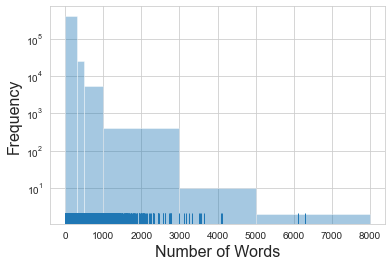

In [17]:
sns.distplot(full_corpus['Number of Words'],kde=False, bins=[0, 300, 500, 1000, 3000, 5000, 8000], rug=True)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Number of Words', fontsize=16)
plt.yscale('log')
plt.show()

In [18]:
below_512 = sum((full_corpus['Number of Words']<=512))
above_512 = sum((full_corpus['Number of Words']>512))

assert (below_512 + above_512) == full_corpus.shape[0]
print('Total amount with fewer than or equal to 512 tokens: {}'.format(below_512))
print('Percentage of total data: {:.2f}'.format(below_512/full_corpus.shape[0]))

Total amount with fewer than or equal to 512 tokens: 427440
Percentage of total data: 0.99


We can see that many documents have less than 512 words.  This is important in using BERT.  We have a limit on how many words the BERT model can take as inputs (512 tokens), and documents with more words see a performance decrease with BERT. 

For the time being, I am only going to look at documents with 512 tokens or fewer.  In the future, this will need to change because a substantial amount of our subset has more than 512 tokens.

In [19]:
# Dropping rows that have more than 512 tokens
subset_corpus = full_corpus[full_corpus['Number of Words'] <= 512]
assert (max(subset_corpus['Number of Words'])) == 512
print(subset_corpus.shape)
subset_corpus.head()

(427440, 4)


,paper_id,section,text,Number of Words
0,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,abstract,new antiaids treatments must be continually de...,123
1,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,in the absence of a curative treatment the hig...,193
2,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,tetramers of in are formed by the reciprocal s...,133
3,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,hindering the assembly of in functional multim...,265
4,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,,based on the structure of fab specific to in c...,70


## Generate BERT Embeddings

For this section, I had trouble running on my local machine.  Having to switch to colab to run bert embeddings.  I am saving the pandas df subset_corpus so that I can easily load it in colab.

## Cluster Embeddings

### Expectation-Maximization using GMMs Clustering

In [20]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
from sklearn.mixture import GaussianMixture as GMM
# gmm = GMM(n_components=4).fit(X)
# labels = gmm.predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

#### Find Best Number of Components

In [21]:
# Find the knee in the graph

### DBSCAN Clustering

In [22]:
from sklearn.cluster import DBSCAN

In [23]:
# dbscan_clustering = DBSCAN(eps=3, min_samples=15).fit(X)

### Clustering Comparison using Silhouette Coefficients 

In [24]:
from sklearn.metrics import silhouette_score

## UMAP Dimensionality Reduction

## Cluster Visualization